In [2]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import EWMA
from quantopian.pipeline.filters import Q1500US
from quantopian.pipeline.data.morningstar import asset_classification
from quantopian.pipeline.data.morningstar import operation_ratios
from quantopian.pipeline.data.morningstar import valuation_ratios
from quantopian.pipeline.factors import CustomFactor

We will make a pipeline. At each time over a given time interval (e.g. 01-01-15 to 01-01-16), we have an associated data frame. In each time's dataframe, we have each stock in our stock universe, the stocks' prices and then any other factors we wish to include. We can then test for correlations between stocks prices, over the time interval, and these factors.

In [3]:
def make_pipeline():
    
    #An example of creating a factor, in this case a momentum factor
    ema_20 = EWMA(inputs=[USEquityPricing.close], window_length=20, decay_rate=0.94)
    ema_50 = EWMA(inputs=[USEquityPricing.close], window_length=50, decay_rate=0.94)
    percent_difference = (ema_20 - ema_50) / ema_50
    
    morningstar_sector = asset_classification.morningstar_sector_code.latest
    
    #Can plug in any factors you wish to test. Don't need three.
    #Here I am using my knowledge of fundamentals to create a value factor. If fix assets turnover is good, 
    #the company can generate sales efficientl. If net margin is good, then the company is good at converting
    #these sales into profit. And finally, if revenue growth is good, then the company is likely to continue
    #this efficient profit generation into the near future so we should long it.
    testing_factor_1 = operation_ratios.fix_assets_turonver.latest
    testing_factor_2 = operation_ratios.net_margin.latest
    testing_factor_3 = operation_ratios.revenue_growth.latest
    
    universe = (testing_factor_1.notnull() & testing_factor_2.notnull() & testing_factor_3.notnull() & morningstar_sector.eq(102))
    
    testing_factor_1 = testing_factor_1.rank(mask=universe, method='average')
    testing_factor_2 = testing_factor_2.rank(mask=universe, method='average')
    testing_factor_3 = testing_factor_3.rank(mask=universe, method='average')
    
    testing_factor = testing_factor_1 + testing_factor_2 + testing_factor_3
    
    pipe = Pipeline(columns={'Sector': morningstar_sector,
                            'Testing Factor': testing_factor},
                   screen = universe
                   )
    
    return pipe

from quantopian.research import run_pipeline

result = run_pipeline(make_pipeline(), start_date = '2015-01-01', end_date = '2016-01-01')
result.head()

Sector  Testing Factor
2015-01-02 00:00:00+00:00 Equity(69 [ACAT])      102          1325.0
                          Equity(162 [AEPI])     102           752.0
                          Equity(247 [AIN])      102           620.0
                          Equity(357 [TWX])      102          1190.0
                          Equity(405 [AMWD])     102          1183.0

In [39]:
assets=result.index.levels[1].unique()

In [40]:
pricing=get_pricing(assets, start_date='2014-12-01', end_date='2016-02-01', fields='open_price')

Now we use alphalens to get a statistical report on the correlation. We can then determine if the factor is likely to generate high alpha or not in our long/short equity algorithm.

Dropped 8.4% entries from factor data: 8.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,3.0,965.0,667.282195,204.203349,72271,50.114067
2,925.0,1841.0,1205.444782,186.336846,71942,49.885933


Returns Analysis


,5D,10D,30D
Ann. alpha,0.050,0.060,0.079
beta,-0.033,-0.033,-0.031
Mean Period Wise Return Top Quantile (bps),7.303,7.939,9.884
Mean Period Wise Return Bottom Quantile (bps),-7.263,-7.906,-9.887
Mean Period Wise Spread (bps),14.565,15.845,19.772


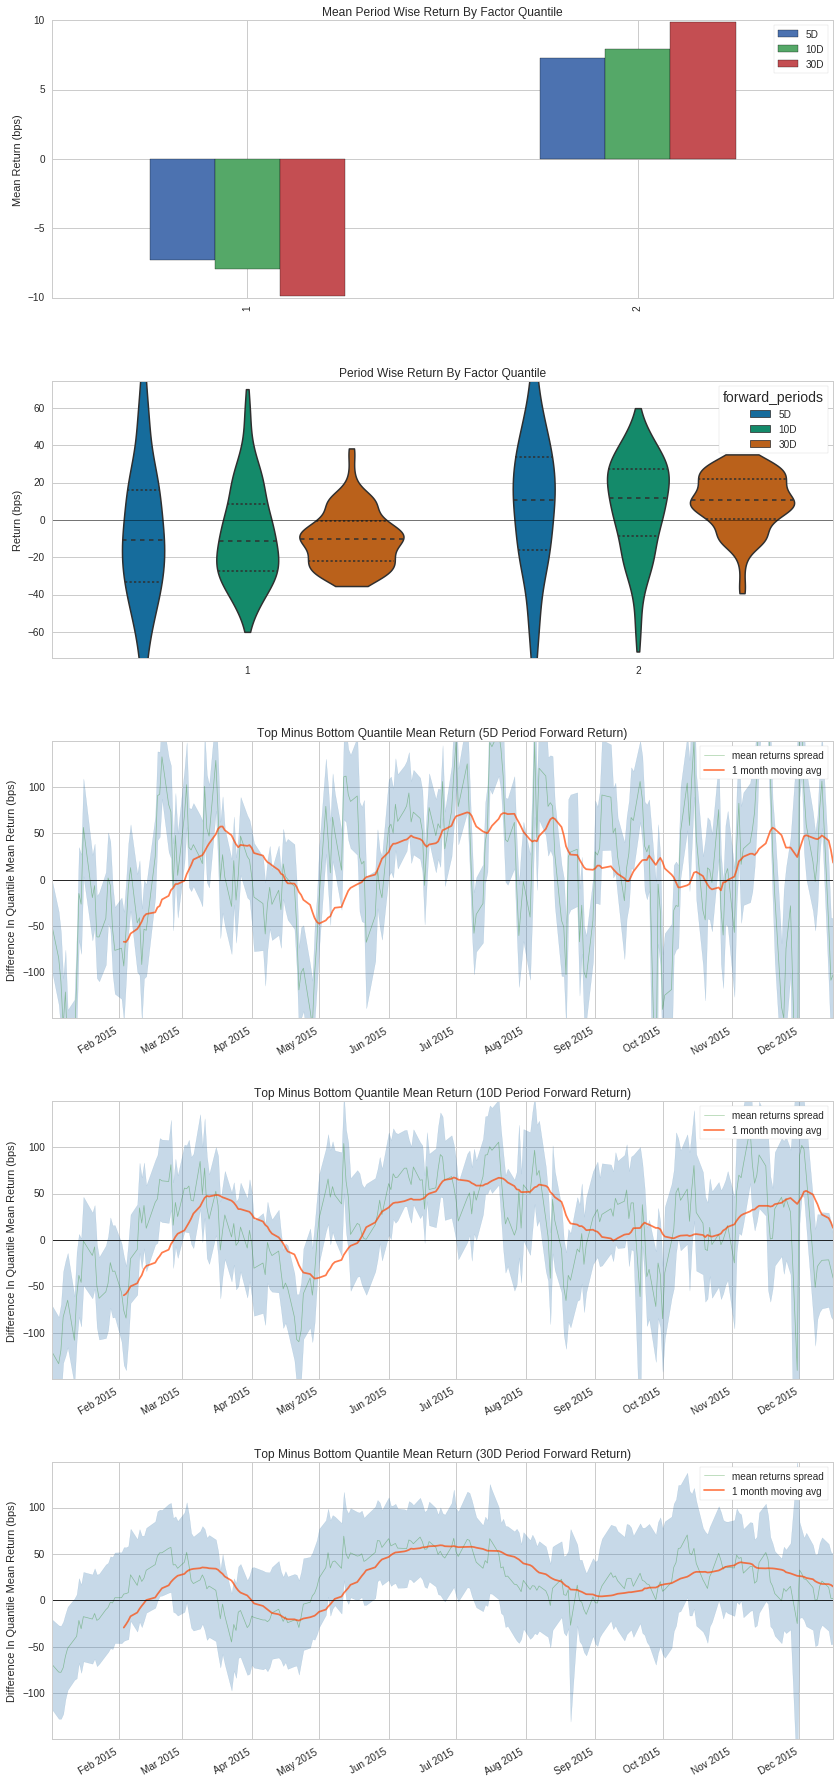

Information Analysis


,5D,10D,30D
IC Mean,0.037,0.045,0.062
IC Std.,0.067,0.071,0.078
Risk-Adjusted IC,0.552,0.634,0.794
t-stat(IC),8.590,9.867,12.347
p-value(IC),0.000,0.000,0.000
IC Skew,-0.163,-0.213,-0.002
IC Kurtosis,0.333,-0.477,-0.611


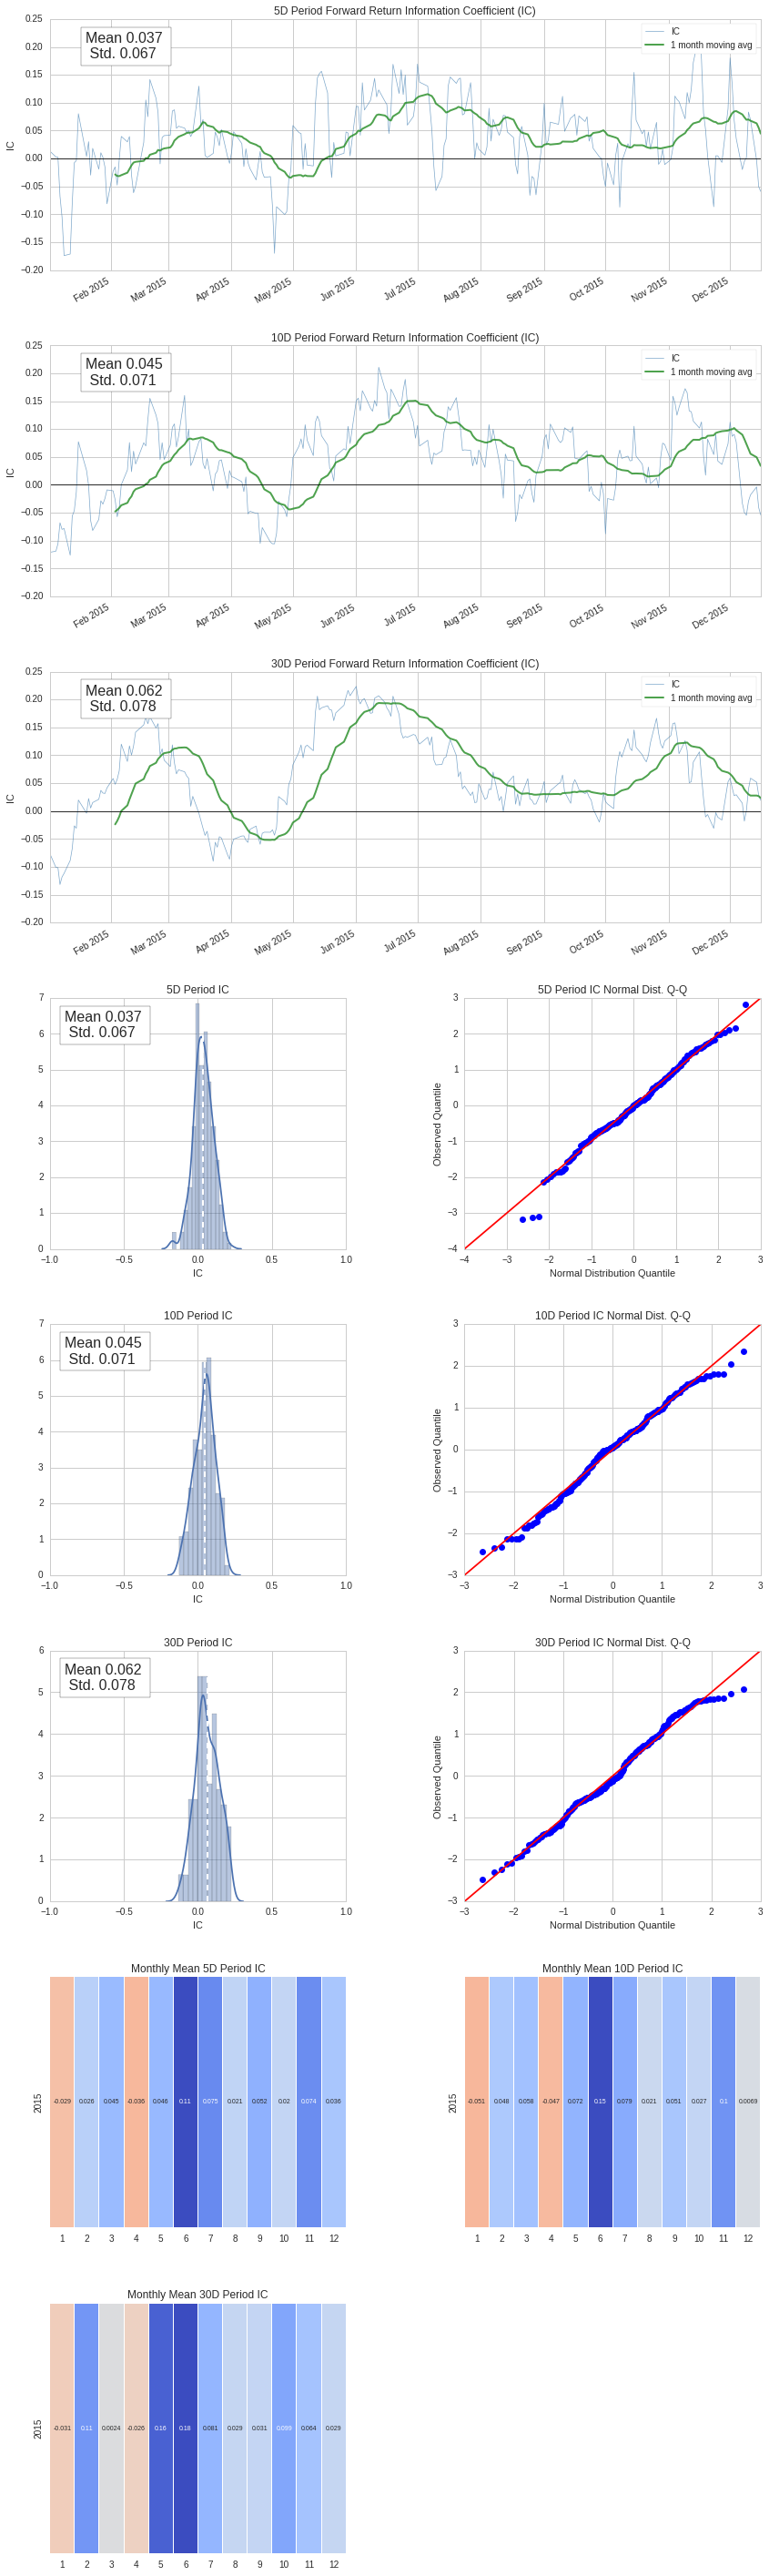

Turnover Analysis


,5D,10D,30D
Quantile 1 Mean Turnover,0.034,0.058,0.136
Quantile 2 Mean Turnover,0.031,0.054,0.128


,5D,10D,30D
Mean Factor Rank Autocorrelation,0.98,0.959,0.874


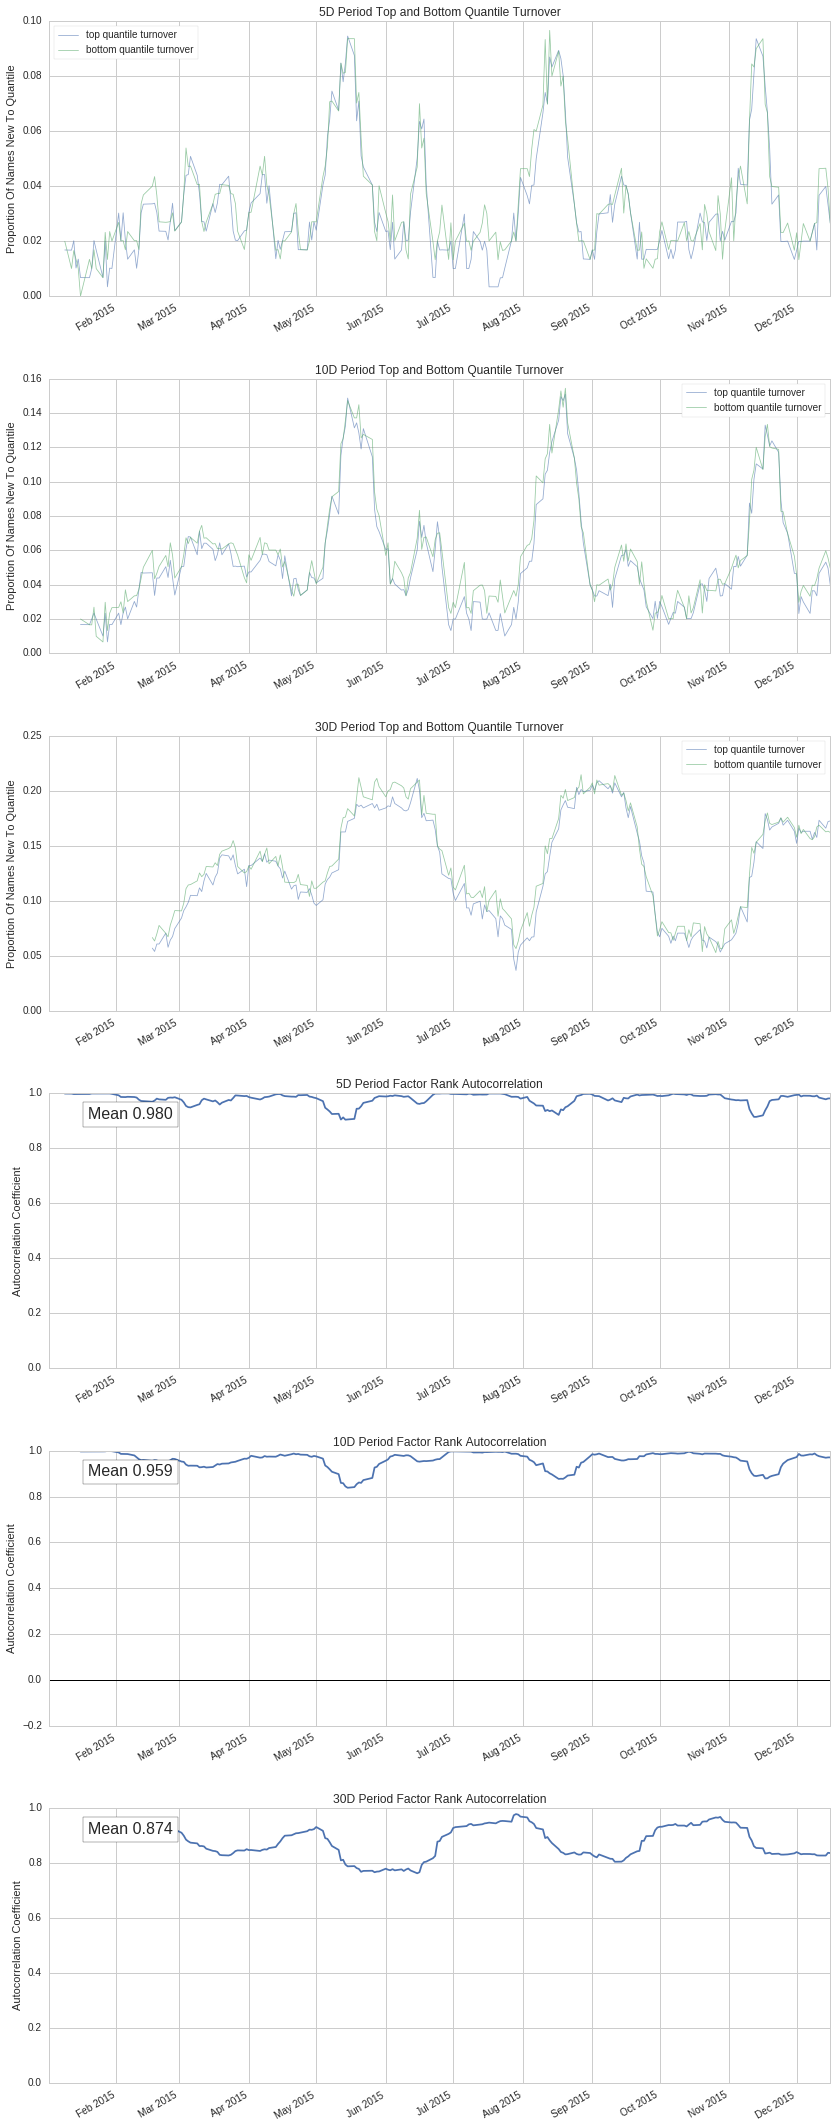

In [42]:
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = result['Testing Factor'], prices = pricing, quantiles=2, periods=(5,10,30))

alphalens.tears.create_full_tear_sheet(factor_data)